In [1]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os, argparse, sys
# from ISIC2020_Dataset import ISIC2020TorchDataset, NORM_CHANNEL_MEAN, NORM_CHANNEL_STD
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms as T
from time import perf_counter
from sklearn.metrics import confusion_matrix, roc_auc_score
from torchsummary import summary
import matplotlib.pyplot as plt

# from DarwinNet_659MF import DarwinNetV2, IntDarwinNetV2, ResHead

In [2]:
import os
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset

NORM_CHANNEL_MEAN = [0.806, 0.621, 0.592]
NORM_CHANNEL_STD = [0.151, 0.177, 0.203]

class ISIC2020TorchDataset(Dataset):
    def __init__(self, data_files, isic_image_dir, targets=None, transform=None):
        self.isic_image_dir = isic_image_dir
        self.data = data_files
        self.targets = targets
        self.transform = transform

    def __len__(self):
        print(len(self.data))
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.isic_image_dir, self.data[idx])
        image = pil_loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
            
        if self.targets is not None:
            target = self.targets[idx]
            return image, target
        else: 
            return image, self.data[idx]

In [3]:
"""

Module for building ResNet Module according to different config file
"""
from torch.nn import Module
import torch.nn as nn
import warnings
from collections import OrderedDict


def conv2d(w_in, w_out, k, *, stride=1, groups=1, dilation=1, bias=False):
    """Helper for building a conv2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    s, p, g, b = stride, (k - 1) // 2, groups, bias
    return nn.Conv2d(w_in, w_out, k, stride=s, padding=p, groups=g, bias=b)


def norm2d(w_in):
    """Helper for building a norm2d layer."""
    return nn.BatchNorm2d(num_features=w_in, eps=1e-5, momentum=0.1)


def pool2d(_w_in, k, *, stride=1):
    """Helper for building a pool2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    return nn.MaxPool2d(k, stride=stride, padding=(k - 1) // 2)


def pool2d_average(_w_in, k, *, stride=1):
    """Helper for building a pool2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    return nn.AvgPool2d(k, stride=stride, padding=(k - 1) // 2)


def gap2d(_w_in):
    """Helper for building a gap2d layer."""
    return nn.AdaptiveAvgPool2d((1, 1))


def linear(w_in, w_out, *, bias=False):
    """Helper for building a linear layer."""
    return nn.Linear(w_in, w_out, bias=bias)


def activation():
    """Helper for building an activation layer."""
    return torch.nn.SiLU()


def get_transformation_function(func_name):
    "Returns the transformation function for ResNet Module"
    functions_available = {"basic": BasicTransform, "bottleneck": BottleneckTransform}
    try:
        func = functions_available[func_name]
        return func
    except:
        raise (ValueError("Function not available"))


class BasicTransform(Module):
    """Basic transformation: 3x3, BN, AF, 3x3, BN."""

    expansion: int = 1

    def __init__(
        self,
        inplanes,
        channels,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        attn=False,
    ):
        super(BasicTransform, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        self.stride = stride
        self.inplanes = inplanes
        self.channels = channels

        if stride != 1:
            self.avgpool = nn.AvgPool2d(2, stride=stride)
            self.conv1 = conv2d(self.inplanes, self.channels, 3, groups=4)
        else:
            self.conv1 = conv2d(
                self.inplanes, self.channels, 3, stride=self.stride, groups=4
            )

        # self.conv1 = conv2d(self.inplanes, self.channels, 3, stride=self.stride)
        self.bn1 = norm2d(self.channels)
        self.relu = activation()
        self.conv2 = conv2d(self.channels, self.channels, 3, groups=4)
        self.bn2 = norm2d(self.channels)
        self.downsample = downsample
        self.attn = attn
        # self.softmax = nn.Softmax()

    def forward(self, x):
        identity = x

        if self.stride != 1:
            out = self.avgpool(x)
            out = self.conv1(out)
        else:
            out = self.conv1(x)
        # out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.attn:
            # print("Using Attn in Basic Block")
            if self.downsample is not None:
                identity = self.downsample(x)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    out = torch.nn.functional.softmax(out)
                out = torch.mul(out, identity)
            else:
                out += identity
        else:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.relu(out)

        return out


class BottleneckTransform(Module):
    """Bottleneck transformation: 1x1, BN, AF, 3x3, BN, AF, 1x1, BN."""

    expansion: int = 2

    def __init__(
        self,
        inplanes,
        channels,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        attn=False,
    ):
        super(BottleneckTransform, self).__init__()
        width = int(channels * (base_width / 64.0)) * groups
        self.stride = stride
        self.conv1 = conv2d(inplanes, width, 1, groups=1)
        self.bn1 = norm2d(width)

        if stride != 1:
            self.avgpool = nn.AvgPool2d(2, stride=stride)
            self.conv2 = conv2d(width, width, 3, stride=1, groups=4, dilation=dilation)
        else:
            self.conv2 = conv2d(
                width, width, 3, stride=stride, groups=4, dilation=dilation
            )

        # self.conv2 = conv2d(width, width, 3, stride=stride, groups=groups, dilation=dilation)
        self.bn2 = norm2d(width)
        self.conv3 = conv2d(width, channels * self.expansion, 1, groups=1)
        self.bn3 = norm2d(channels * self.expansion)
        self.relu = activation()
        self.downsample = downsample
        self.stride = stride
        self.width = width
        self.inplanes = inplanes
        self.channels = channels
        self.groups = groups
        self.dilation = dilation
        self.downsample = downsample
        self.attn = attn

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.stride != 1:
            out = self.avgpool(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.attn:
            if self.downsample is not None:
                identity = self.downsample(x)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    out = torch.nn.functional.softmax(out)
                out = torch.mul(out, identity)
            else:
                out += identity
        else:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.relu(out)

        return out


class ResHead(Module):
    """ResNet head: AvgPool, 1x1."""

    def __init__(self, w_in, num_classes):
        super(ResHead, self).__init__()
        self.w_in = w_in
        self.num_classes = num_classes
        self.avg_pool = gap2d(w_in)
        self.fc = linear(w_in, num_classes, bias=True)

    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return x
        # x = self.fc(x)
        # return x


class DarwinStemIN(Module):
    """ResNet stem for ImageNet: 7x7, BN, AF, MaxPool."""

    def __init__(self, w_in, w_out):
        super(DarwinStemIN, self).__init__()
        self.w_in = w_in
        self.w_out = w_out

        self.relu = activation()

        self.conv1 = conv2d(w_in, w_out, 3, stride=2)
        self.bn1 = norm2d(w_out)
        self.conv2 = conv2d(w_out, w_out, 3, stride=1, groups=4)
        self.bn2 = norm2d(w_out)

        self.pool = pool2d_average(w_out, 3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.pool(x)

        return x


class DarwinNetV2(Module):
    """DarwinNetV2 model."""

    def __init__(self, blockspecs, input_shape, num_classes, in_chans = 3, model_structure=[[None]]):
        super(DarwinNetV2, self).__init__()
        self.blockspecs = blockspecs
        
        self.channels = [max(4, b[0] - b[0] % 4) for b in self.blockspecs]
        self.model_depth = [b[1] for b in self.blockspecs]
        self.attn = [b[6] for b in self.blockspecs]
        
        
        self.replace_stride_with_dilation = [False for i in range(len(self.channels))]
        self.module_types = ["basic", "basic", "bottleneck", "bottleneck"]

        self.num_channels = len(self.channels)
        self.blocks = []
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dilation = 1
        self.base_width = 64
        self.groups = 1
        assert self.num_channels == len(self.model_depth)
        self._construct_imagenet()

    def _construct_imagenet(self):
        depth = self.model_depth
        self.inplanes = 32
        self.stem = DarwinStemIN(self.input_shape[2], self.inplanes)

        for i in range(len(self.channels)):
            if i == 0:
                self.blocks.append(
                    self._make_layer(
                        get_transformation_function(self.module_types[i]),
                        self.channels[i],
                        stride=1,
                        depth=depth[i],
                        attn=self.attn[i],
                    )
                )
            else:
                self.blocks.append(
                    self._make_layer(
                        get_transformation_function(self.module_types[i]),
                        self.channels[i],
                        stride=2,
                        depth=depth[i],
                        dilate=self.replace_stride_with_dilation[i - 1],
                        attn=self.attn[i],
                    )
                )
        self.blocks = nn.ModuleList(self.blocks)
        self.head = ResHead(
            self.channels[self.num_channels - 1]
            * get_transformation_function(
                self.module_types[self.num_channels - 1]
            ).expansion,
            self.num_classes,
        )
        # model = nn.Sequential(*[self.stem, self.blocks, self.head])
        # return model

    def _make_layer(self, module_type, channels, stride, depth, dilate=False, attn=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        if stride != 1:
            downsample = nn.Sequential(
                nn.AvgPool2d(2, stride=stride),
                conv2d(
                    self.inplanes,
                    channels * module_type.expansion,
                    1,
                    stride=1,
                    groups=1,
                ),
                norm2d(channels * module_type.expansion),
            )
        elif self.inplanes != channels * module_type.expansion:
            downsample = nn.Sequential(
                conv2d(
                    self.inplanes,
                    channels * module_type.expansion,
                    1,
                    stride=stride,
                    groups=1,
                ),
                norm2d(channels * module_type.expansion),
            )

        layers = []
        layers.append(
            module_type(
                self.inplanes,
                channels,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                attn=attn,
            )
        )
        self.inplanes = channels * module_type.expansion
        for _ in range(1, depth):
            layers.append(
                module_type(
                    self.inplanes,
                    channels,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    attn=attn,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        for i in range(self.num_channels):
            x = self.blocks[i](x)
        x = self.head(x)
        return x
    
class IntDarwinNetV2(DarwinNetV2):
    def __init__(self, output_layer, *args):
        self.output_layer = output_layer
        super().__init__(*args)

        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [29]:
def args_parser():
    parser = argparse.ArgumentParser(description='CancerNet-SCa x AttendNeXt Inferece')
    parser.add_argument('--weightspath', default='final-model.pth', type=str, help='Path to trained model weights')
    parser.add_argument('-mc', '--model-config', default='DarwinNet_XA_325MF.yml', help='Path to model config file')
    parser.add_argument('-dd', '--data-dir', type=str, default='ISIC_2020_Test_Input/', help='Sample image directory')
    parser.add_argument('-ttf', '--test-split-file', type=str, default='test_input.csv', help='CSV file with one test input')
    parser.add_argument('-tf', '--split-file', type=str, default='ISIC_2020_Training_GroundTruth.csv', help='CSV file with actual results for image directory')
    parser.add_argument('-tsf', '--test-file', type=str, default='ISIC_2020_Test_Metadata.csv', help='CSV file with test results for image directory')
    parser.add_argument('-sz', '--size', type=int, default=224, help='Square image size')
    parser.add_argument('-mp', '--mixed-precision', action='store_true', help='Flag to enable mixed-precision')
    parser.add_argument('-df', '--data-file-name', type=str, default='sample_data_predictions.csv', help='Name of csv file for predictions')
    parser.add_argument('-gi', '--gpu-id', type=int, default=0, help='GPU device ID')
    parser.add_argument("-f", required=False)

    args, unknown = parser.parse_known_args()
    return args

args = args_parser()
# start_time = perf_counter()

print("Starting script")

num_classes = 1

HYPERPARAMETERS = yaml.load(open(args.model_config, "r"), Loader=yaml.FullLoader)
config = edict(HYPERPARAMETERS)
device = 'cuda:{}'.format(args.gpu_id) if args.gpu_id >= 0 else 'cpu'
# device = 'cpu'
model = DarwinNetV2(config.model_cfg, config.input_shape, num_classes)
state_dict = torch.load(args.weightspath, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
print(device)

test_tform = T.Compose([
    T.Resize((args.size, args.size)),
    T.ToTensor(),
    T.Normalize(NORM_CHANNEL_MEAN, NORM_CHANNEL_STD)
])


Starting script
cuda:0


In [8]:
# Read and load data

data_df = pd.read_csv(args.split_file)
data_files = data_df['isic_id'].to_numpy()
actual_vals = data_df['target'].to_numpy()
actual_diag = data_df['diagnosis'].to_numpy()

In [27]:
# Used for when running a single test input
from torchvision.datasets.folder import pil_loader

test_data_df = pd.read_csv(args.test_file)
test_data_files = test_data_df['isic_id'].to_numpy()
# test_actual_vals = test_data_df['target'].to_numpy()

image_dir = 'ISIC_2020_Test_Input/'
image_path = os.path.join(image_dir, test_data_files[0])

# image = pil_loader(image_path)
# # print(type(image))
# test_input_img = test_tform(image)
# test_input_img = test_input_img.unsqueeze(0)

# model.eval()
# with torch.no_grad():
#     data = test_input_img.to(device)
#     with autocast(enabled='store_true'):

#         test_embedding = model(data)

isic_dataset = ISIC2020TorchDataset(
    test_data_files, args.data_dir, transform=test_tform
)
test_loader = DataLoader(isic_dataset, batch_size=256, shuffle=False, num_workers=0)

In [31]:
# Test how long it takes to get the embeddings of a single input image.

start_time = perf_counter()

# all_predictions = []
test_image_names = []
test_embeddings = []
model.eval()
with torch.no_grad():
    for data, image_names in test_loader:
        data = data.to(device)
        with autocast(enabled=args.mixed_precision):
            embeddings = model((data))

            # print(embeddings.detach().cpu().numpy().shape)
            # logits = torch.squeeze(model(data))
            # predictions = torch.sigmoid(logits)
            # save embeddings here
        # test_embeddings.append(embeddings.detach().cpu().numpy())
        test_embeddings.extend(embeddings.detach().cpu().numpy())
        for image_name in image_names:
            test_image_names.append(image_name)

end_time = perf_counter()
actual_vals = np.array(actual_vals)
diagnosis = np.array(actual_diag)
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time}")


10982
Elapsed time: 1244.9401239


AttributeError: 'list' object has no attribute 'shape'

In [32]:
print(np.array(test_embeddings).shape)

(10982, 744)


In [ ]:
# RUN ONLY IF NECESSARY - gets embeddings and image names (Consider moving image names separately or keeping original)

# all_image_names = [] # Comment out precaution
# all_embeddings = [] # COP
model.eval()
start_time = perf_counter()
with torch.no_grad():
    for data, image_names in test_loader:
        data = data.to(device)
        with autocast(enabled=args.mixed_precision):
            embeddings = model((data))
            
            print(embeddings.detach().cpu().numpy().shape)
            # save embeddings here
        # all_embeddings.append(embeddings.detach().cpu().numpy())
        all_embeddings.extend(embeddings.detach().cpu().numpy())
        for image_name in image_names:
            all_image_names.append(image_name)
        print(f"current all_embeddings vector shape: {np.array(all_embeddings).shape}")

In [ ]:
# RUN ONLY IF NECESSARY - Writes pickle file of image names
import csv
import pickle

# my_data = {'image_names': all_image_names} # COP
output = open('image_names.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# np.savez('embeddings.npz', all_embeddings)


In [49]:
import pickle
my_data = {'test_embeddings': test_embeddings} # COP
output = open('test_embeddings.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# np.savez('embeddings.npz', all_embeddings)

In [9]:
# RUN ONLY IF NECESSARY - Reads pickle file of embeddings

import csv
import pickle

pkl_file = open('embeddings1.pkl', 'rb')

stored_embeddings = pickle.load(pkl_file)['embeddings'] # COP

print(np.array(stored_embeddings).shape)

pkl_file.close()

(33126, 744)


In [10]:
# RUN ONLY IF NECESSARY - Reads pickle file of image names

pkl_file = open('image_names.pkl', 'rb')

stored_image_names = pickle.load(pkl_file)['image_names'] # COP

print(np.array(stored_image_names).shape)

pkl_file.close()

(33126,)


In [11]:
# split data into testing and training
from sklearn.model_selection import train_test_split
from collections import Counter

train_ratio = 0.70
validation_ratio = 0.29
test_ratio = 0.01

X = stored_embeddings
X = pd.DataFrame(X)
y = actual_vals
y = pd.Series(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=1,  stratify=y)

# X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1, stratify=Y_test)

print(f"Train Ratio: {Counter(Y_train)}")
# print(f"Validation Ratio: {Counter(Y_val)}")
print(f"Test Ratio: {Counter(Y_test)}")
print(len(X_test))

Train Ratio: Counter({0: 22779, 1: 409})
Test Ratio: Counter({0: 9763, 1: 175})
9938


In [22]:
# Apply SMOTE oversampling
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X_train, Y_train)

# X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X_smote, y_smote, test_size=1-train_ratio, random_state=1,  stratify=y_smote)

# X_val_s, X_test_s, Y_val_s, Y_test_s = train_test_split(X_test_s, Y_test_s, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1, stratify=Y_test_s)

# print(len(X_test_s))
# print(np.array(X_train_s).shape)
# print(X_test_s.index)
# print(Y_test_s.index)
Counter(y_smote)

Counter({0: 22779, 1: 22779})

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import math

def most_common(lst):
    return max(set(lst), key=lst.count)

def plot_similar_images(indices_list, input_ind, Y_val, y_train):
    correct_vals = 0
    false_pos = 0
    false_neg = 0
    # input_name = stored_image_names[input_ind]
    # img_path = os.path.join(args.data_dir + input_name)
    # print("Input:")
    # print(img_path)
    acc = Y_val.loc[input_ind]
    # print(f"Benign/Malignant: {actual_vals[input_ind]}")
    # print(f"Diagnosis: {actual_diag[input_ind]}")
    # img = Image.open(img_path).convert("RGB")
    # plt.imshow(img)
    # plt.show()
    # print("Results")
    diagnoses = []
    for index in indices_list:
        # img_name = stored_image_names[index]
        # img_path = os.path.join(args.data_dir + img_name)
        # print(img_name)
        prediction = y_train.iloc[index]
        
        diagnoses.append(prediction)
        # print(img_path)
        # print(f"Benign/Malignant: {actual_vals[index]}")
        # print(f"Diagnosis: {actual_diag[index]}")
       
        # img = Image.open(img_path).convert("RGB")
        # plt.imshow(img)
        # plt.show()
    # print(diagnoses)
    if 1 in diagnoses:
        common_diag = 1
    else:
        common_diag = 0
    # common_diag = most_common(diagnoses)  
    # print(f"Prediction: {common_diag}")
    if common_diag == acc:
        correct_vals = 1
    elif acc == 0:
        false_pos = 1
        # print("FALSE POSITIVE")
    elif acc == 1:
        false_neg = 1
        # print("FALSE NEGATIVE")
    # print(correct_vals)
    return common_diag, correct_vals, false_pos, false_neg

In [47]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score, fbeta_score, confusion_matrix, average_precision_score, f1_score


def predict_weighted(knn, k, x_test, Y_train, weight):
    dists, indices = knn.kneighbors(x_test)
    indices_list = indices.tolist()[0] # returned indices is the integer-location, not the dataframe.index

    # Find the corresponding labels of the retrieved neighbors
    labels = np.array(Y_train.iloc[indices_list])

    # Create Weight factor array and apply on dists array
    weights = (labels * 1/weight) + 1
    dists = np.divide(dists[0], weights)

    # Combine the dists with the indices and weights to sort all according to the weighted dists
    neighbors = np.column_stack((dists, indices_list, labels))
    neighbors = neighbors[np.argsort(neighbors[:,0])]

    # Get the new indices of the smallest k weighted distances
    final_indices = [int(ind) for ind in neighbors[0:k+1,1]]
    neighbor_targets = [int(ind) for ind in neighbors[0:k+1,2]]
    
    # pstvs = (np.array(neighbor_targets) == 1).sum()
    # if pstvs >= 2:
    #     pred = 1
    # else:
    #     pred = 0

    pred = 1 if 1 in neighbor_targets else 0

    return final_indices, pred


def predict(knn, i, X_val, Y_train):
    input_emb = np.array(X_val.loc[i]).reshape(1, -1)
    dists, indices = knn.kneighbors(input_emb)
    indices_list = indices.tolist()[0]
    predictions = np.array(Y_train.iloc[indices_list])
    pstvs = (predictions == 1).sum()

    if pstvs > 2:
        pred = 1
    else:
        pred = 0

    return indices_list, pred

In [48]:
test_x = pd.DataFrame(test_embeddings)
test_knn = NearestNeighbors(n_neighbors=50, metric="euclidean")
test_knn.fit(X)
test_weight = 8
test_predictions = []
test_images = test_data_df['image'].to_numpy()

for i in test_x.index:
    x_test = np.array(test_x.loc[i]).reshape(1, -1)
    indices_list, pred = predict_weighted(test_knn, 5, x_test, y, test_weight)
    test_predictions.append(pred)

predictions_df = pd.DataFrame.from_dict({'image_name': test_images, 'target': test_predictions})
predictions_df.to_csv('sample_data_predictions_weight_8_2.csv', header=True, index=False)


In [20]:
knn = NearestNeighbors(n_neighbors=100)
knn.fit(X)

indices_list, pred = predict_weighted(knn, 5, np.array(test_embedding.reshape(1, -1)), y, 8.5)

print(indices_list)

for ind in indices_list:
    print(stored_image_names[ind])

print(pred)


[1291, 14963, 19842, 2550, 14474, 6952]
ISIC_0490442.jpg
ISIC_4577414.jpg
ISIC_6024863.jpg
ISIC_0865521.jpg
ISIC_4434221.jpg
ISIC_2173487.jpg
0


In [ ]:
# Non-weighted KNN testing
knn = NearestNeighbors(n_neighbors=20, metric="euclidean")
knn.fit(X_train)
counter = 0
predictions = []

for i in X_val.index:
    print(counter)
    indices_list, pred = predict(knn, i, X_val, Y_train)
    predictions.append(pred)
    counter += 1


# print("confusion_matrix: \n", confusion_matrix(Y_val, predictions))


# temp_embedding = np.array(X_val.loc[0]).reshape(1, -1)

# print(temp_embedding)
# print(X_val.index[0])
# print(stored_image_names[X_val.index[0]])
# final_indices, _, pred = predict(knn, 5, temp_embedding, y, 8)
# print(final_indices)
# print(pred)
# indices = X.iloc[final_indices].index.tolist()
# print(indices)

# for ind in final_indices:
#     print(stored_image_names[ind])

In [14]:
# Weighted KNN Testing
knn100 = NearestNeighbors(n_neighbors=100, metric="euclidean")
knn100.fit(X_train)
knn50 = NearestNeighbors(n_neighbors=50, metric="euclidean")
knn50.fit(X_train)
# all_preds100 = []
# all_preds50 = []
weights = np.linspace(1, 10, num=10)
auprc_scores = []
auroc_scores = []
f1_scores = []
fb_scores = []
k = 5

for weight in weights:
    predictions100 = []
    predictions50 = []
    for i in X_test.index:
        x_test = np.array(X_test.loc[i]).reshape(1, -1)
        indices_list, pred = predict_weighted(knn100, 5, x_test, Y_train, weight)
        predictions100.append(pred)
        indices_list, pred = predict_weighted(knn50, 5, x_test, Y_train, weight)
        predictions50.append(pred)
    all_preds100.append(predictions100)
    all_preds50.append(predictions50)

# Accuracy and AUC-ROC Scores
scores = pd.DataFrame(list(zip(weights, f1_scores, fb_scores, auroc_scores, auprc_scores)), columns =["Weight Factor", "F1 Score", "F-beta Score", "AUC-ROC Score", "AUC-PR Score"]) 
print(scores)


Empty DataFrame
Columns: [Weight Factor, F1 Score, F-beta Score, AUC-ROC Score, AUC-PR Score]
Index: []


(4.392580598939676, 0.12925656914844713)
(4.531197989801197, 0.1282495894909688)
(4.762808980035734, 0.12672820364895074)
(4.968365208714452, 0.1525604190712954)
(5.137069192317811, 0.17146720994766237)
(5.380257050392973, 0.17650314640336542)
(5.593874254950971, 0.17524499905072577)
(5.833331328320802, 0.1739629236199157)
(6.17111888853537, 0.1723506246605106)
(6.4304583889630615, 0.177649655451283)
(6.643663481705896, 0.18951254204387624)
(6.720948369238175, 0.20816631130063967)
(6.936932699524643, 0.21355096359388204)
(6.979893796140396, 0.23835763774331903)
(7.149704663904851, 0.24384238719642445)
(7.288420474818169, 0.24945589150588005)
(7.383781512605042, 0.2552376595153674)
(7.505691336775674, 0.2609024100115694)
(7.4498500072812, 0.27951459153463254)
(7.500014773230905, 0.28541220035080883)
(7.66650558743582, 0.28473241627375684)
(7.866067555004649, 0.2839594745261525)
(8.004982655313782, 0.28344650720172904)
(8.050661942341762, 0.29541041653254363)
(8.179767632138766, 0.294945

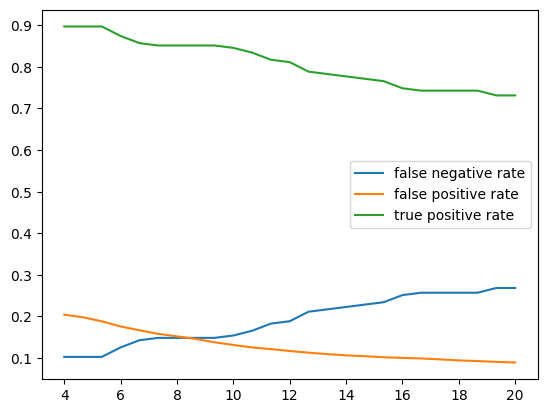

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


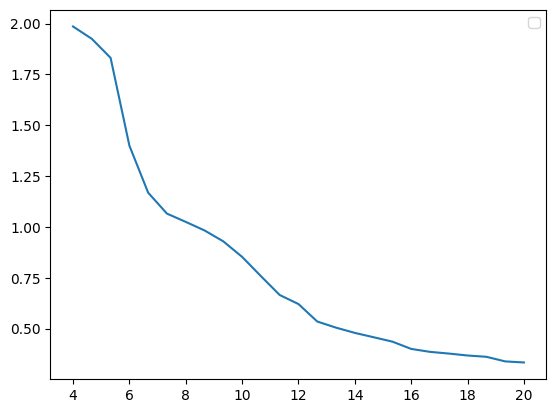

In [33]:
from sklearn import metrics 
auprc_scores = []
auroc_scores = []
f1_scores = []
fb_scores = []
recalls = []
fnrs = []
fprs = []
tprs = []

def fnr(fn, tp):
    return fn/(tp + fn)

def fpr(fp, tn):
    return fp/(tn + fp)

def tpr(tp, fn):
    return tp/(tp + fn)

for preds in all_preds50:
    print(metrics.class_likelihood_ratios(Y_test, preds))
    tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
    fnrs.append(fnr(fn, tp))
    fprs.append(fpr(fp, tn))
    tprs.append(tpr(tp, fn))
    auprc_scores.append(average_precision_score(Y_test, preds))
    auroc_scores.append(roc_auc_score(Y_test, preds))
    f1_scores.append(f1_score(Y_test, preds, average='weighted'))
    fb_scores.append(fbeta_score(Y_test, preds, beta=2.5, average="weighted"))
    precision, recall, threshold = metrics.precision_recall_curve(Y_test, preds)
    recalls.append(recall)

plt.show()
    

# Accuracy and AUC-ROC Scores
scores2 = pd.DataFrame(list(zip(weights, f1_scores, fb_scores, auroc_scores, auprc_scores, recalls)), columns =["Weight Factor", "F1 Score", "F-beta Score", "AUC-ROC Score", "AUC-PR Score", "Recall"]) 
print(scores2)

plt.figure()
plt.plot(weights, fnrs, label='false negative rate')
plt.plot(weights, fprs, label='false positive rate')
plt.plot(weights, tprs, label='true positive rate')
plt.legend()
plt.show()

plt.figure()
plt.plot(weights, np.divide(fprs, fnrs))
plt.legend()
plt.show()

/var/folders/hg/s6dbbw4x4k7dtxnvgrmqd8yc0000gn/T/ipykernel_43421/1966989178.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(weights)


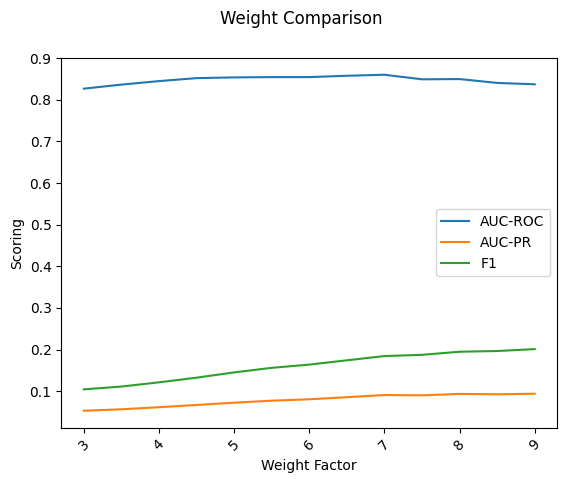

[ 2  3  4  5  6  7  8  9 10 11 12 13 14]


In [43]:
# Plotting AUC-ROC
fig = plt.figure()
fig.suptitle('Weight Comparison')
ax = fig.add_subplot(111)
plt.plot(weights, auroc_scores, label='AUC-ROC')
plt.plot(weights, auprc_scores, label='AUC-PR')
plt.plot(weights, f1_scores, label='F1')

plt.xlabel('Weight Factor')
plt.ylabel('Scoring')
ax.set_xticklabels(weights)
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(weights)

In [27]:
from sklearn import metrics
print("confusion_matrix: \n", metrics.confusion_matrix(Y_val, predictions))

NameError: name 'predictions' is not defined

In [10]:
# Cross validation measurements
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier 
import seaborn as sns

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=0)

models = [KNeighborsClassifier(n_neighbors=5, weights='distance'), LogisticRegression(random_state=0), BalancedRandomForestClassifier(random_state=0), RUSBoostClassifier(random_state=0), GradientBoostingClassifier(random_state=0)]
names = ["5 Nearest Neighbours", "Logistic Regression", "Random Forest", "Random-Undersampling Boosting", "Gradient Boosting"]
k_values = [5, 7, 9, 11]
cv_scores = []
f1s = []
auroc = []
auprc = []

for model, name in zip(models, names):
    start_time = perf_counter()
    print(f"start classifier = {name}")
    model = model.fit(X_smote, y_smote)
    pred = model.predict(X_val)

    # Display confusion matrix and classification report
    print("confusion_matrix: \n", metrics.confusion_matrix(Y_val, pred))
    clf_report = metrics.classification_report(Y_val, pred, output_dict=True)
    plt.figure()
    plt.title(name)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
    plt.show()
    
    # Run cross validation
    cv_results = cross_validate(model, X_smote, y_smote, cv=cv, scoring=('f1', 'roc_auc', 'average_precision'))

    cv_scores.append(cv_results['test_roc_auc'])
    f1s.append(cv_results['test_f1'].mean())
    print(f"auroc: {cv_results['test_roc_auc'].mean()}")
    auroc.append(cv_results['test_roc_auc'].mean())
    auprc.append(cv_results['test_average_precision'].mean())
    # # acc.append(cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1).mean()) # Storing accuracy values
    # # auc.append(cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean()) # Storing AUC-ROC scores

    end_time = perf_counter()
    
    elapsed_time = end_time - start_time
    print(f"Time elapsed for crossval: {elapsed_time}s")


# Accuracy and AUC-ROC Scores
scores = pd.DataFrame(list(zip(names, f1s, auroc, auprc)), columns =["Algorithm", "F1 Score", "AUC-ROC Score", "AUC-PR Score"]) 
print(scores)

# Plotting AUC-ROC
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cv_scores)
plt.xlabel('Algorithm')
plt.ylabel('AUC-ROC')
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.show()

print(Counter(Y_train))
print(Counter(Y_val))

NameError: name 'f1s' is not defined

In [ ]:
# start_time = perf_counter()
# indices_list, _, dists= find_nearest_k(7, 1, stored_embeddings)
# end_time = perf_counter()

# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time}")

num_embeddings = np.array(X_train).shape[0]
print(f'Number of training data: {num_embeddings}')
corr = 0
f_poss = 0
f_negs = 0
mal_1s = 0

for i in X_val.index:
    print(i)
    indices_list, _, dists= find_nearest_k(7, i, stored_embeddings, X_train)
    correct, f_pos, f_neg, mal_1 = plot_similar_images(indices_list, i)
    corr += correct
    f_poss += f_pos
    f_negs += f_neg
    mal_1s += mal_1
print(corr)

In [99]:
# PCA projection
import plotly.express as px
from sklearn.decomposition import PCA

n_components = 3

pca = PCA(n_components=n_components)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Malignancy'

fig = px.scatter_matrix(
    components,
    color=y,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    opacity=0.75,
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [100]:
# TSNE data visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=270, random_state=42)

X_tsne = tsne.fit_transform(np.array(X))
print(tsne.kl_divergence_)

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, opacity=0.7)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

1.5058304071426392


In [37]:
# determine appropriate perplexity

perplexity = np.arange(50, 300, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(np.array(X_test))
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [148]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Function to find the optimal k value and class weights
def find_optimal_k_and_weights(X_train, y_train, X_test, y_test, k_range, weight_options):
    best_score = 0
    best_k = 0
    best_weights = None
    avg_k_score = []
    
    for k in k_range:
        print(f"k = {k}")
        scores = []
        for weight in weight_options:
            # Initialize the KNeighborsClassifier with the current k and weight
            knn = NearestNeighbors(n_neighbors=k)
            
            # Fit the model on the training data
            knn.fit(X_train)
            
            # Make predictions on the testing data
            y_pred = predict(knn, 5, X_test, y_train, weight)
            
            # Evaluate the accuracy of the predictions
            score = average_precision_score(y_test, y_pred)
            scores.append(score)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_weights = weight

        avg_k_score.append(np.mean(scores), axis=0)
                
    return best_k, best_weights, best_score, avg_k_score

# Range of k values to try
k_range = np.arange(50, 1000, 10)

# Weight options to try
weight_options = np.arange(2, 21)

# Find the optimal k value and class weights
best_k, best_weights, best_score = find_optimal_k_and_weights(X_train, Y_train, X_val, Y_val, k_range, weight_options)

print(f"Best k: {best_k}")
print(f"Best weights: {best_weights}")
print(f"Best accuracy score: {best_score}")


k = 50


TypeError: predict() takes 4 positional arguments but 5 were given

In [146]:
print(scores)

NameError: name 'scores' is not defined

In [ ]:
# Optimize weights and K value

class WeightedKNN:
    def __init__(self, K = 100, k=5, weight=1/5):
        self.K = K
        self.k = k
        self.weight = weight
        self.knn = NearestNeighbors(n_neighbors=self.K)
        self.X_train = None
        self.y_train = None

    def fit(self, X_train):
        self.X_train = X_train
        self.Y_train = Y_train

    def predict(self, X_test):
        predictions = []
        for point in X_test:
            distances = self._compute_distances(point)
            k_nearest_labels = self._get_k_nearest_labels(distances)
            predictions.append(self._most_common_label(k_nearest_labels))
        return predictions

    def _compute_distances(self, x):
        # Calculate the distance between x and all examples in the training set
        distances = []
        for i in len(self.X_train):
            raw_distance = self._euclidean_distance(x, self.X_train[i])
            if self.Y_train[i] is 1:
                weighted_distance = raw_distance/(1 + self.weight)
            else:
                weighted_distance = raw_distance
            distances.append(weighted_distance)
            
        # distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        return distances

    def _get_k_nearest_labels(self, distances):
        # Sort the distances, and return the labels of the k nearest neighbors
        k_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:self.k]
        return [self.Y_train[i] for i in k_indices]

    def _most_common_label(self, labels):
        # Find the most common label among the labels of the k nearest neighbors
        return max(set(labels), key=labels.count)

    @staticmethod
    def _euclidean_distance(x1, x2):
        return sum((xi - xj) ** 2 for xi, xj in zip(x1, x2)) ** 0.5


# Example usage:
# Let's assume we have some training data `X_train` and `y_train`
# and we want to make predictions for test set `X_test`.
# X_train = [[0, 0], [1, 1], [1, 0], [0, 1]]
# y_train = [0, 1, 1, 0]
# X_test = [[0.5, 0.5], [1.5, 1.5]]

# Initialize the KNN model
# knn = KNearestNeighbors(k=3)

# Train the model
# knn.fit(X_train, y_train)

# Make predictions
# predictions = knn.predict(X_test)

# Note: In an actual usage scenario, the data `X_train`, `y_train`, and `X_test` 
# would be numpy arrays or a similar data structure. The provided example with lists is for simplicity.
